## Import Libraries

In [1]:
import sys

sys.path.append('/home/michele.prencipe/tesi/transformer/swin2sr')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from data_loader.read_mrc import read_mrc
from tests.training import *
from skimage import io, color
from utils.utils import set_global_seed
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
set_global_seed(42)

/localscratch/miniforge3/envs/transformer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/localscratch/miniforge3/envs/transformer/lib/python3.9/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Set Directories

In [2]:
from data_loader.biosr_dataset import BioSRDataLoader

# Define your working directory and data directory
work_dir = "."
tensorboard_log_dir = os.path.join(work_dir, "tensorboard_logs")
os.makedirs(tensorboard_log_dir, exist_ok=True)
data_dir = '/group/jug/ashesh/data/BioSR/'


## Load Data

In [3]:
from configs.biosr_config import get_config
config = get_config()

resize_to_shape = (768,768) #to put it into the config

dataset, train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = create_dataset(config, 
                                                datadir='/group/jug/ashesh/data/BioSR/', transform = None, 
                                                noisy_data = False)


Norm Param:  0 0 65535 65535
c1_data shape: (1004, 1004, 68)
c2_data shape: (1004, 1004, 54)


In [4]:
#from configs.biosr_config import get_config
config = get_config()

resize_to_shape = (1004,1004) #to put it into the config
transform = Augmentations()

noisy_dataset, noisy_train_dataset, noisy_val_dataset, noisy_test_dataset, noisy_train_loader, noisy_val_loader, noisy_test_loader = create_dataset(config,
                                                                                                                datadir='/group/jug/ashesh/data/BioSR/',
                                                                                                                transform = None,
                                                                                                                noisy_data = True,
                                                                                                                noisy_factor = 1000,
                                                                                                                gaus_factor = 1000)


Norm Param:  0 0 65535 65535
c1_data shape: (1004, 1004, 68)
c2_data shape: (1004, 1004, 54)


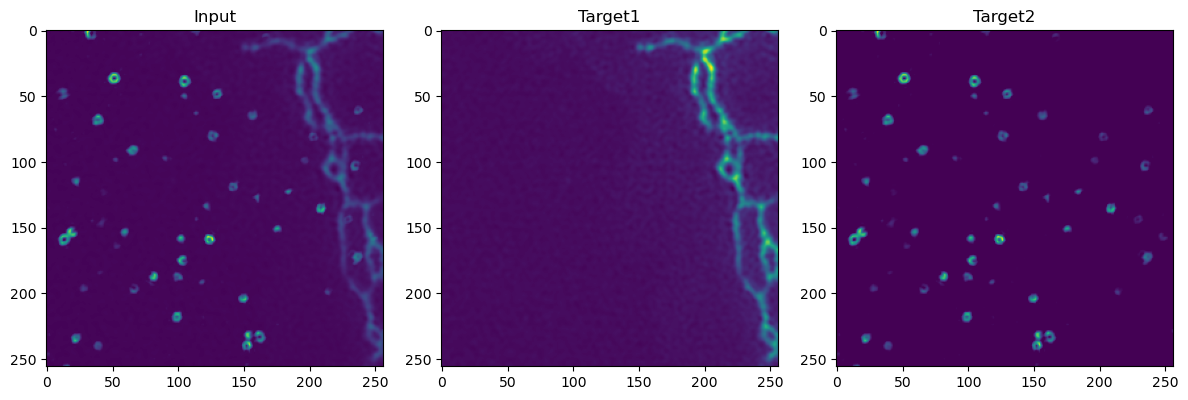

In [5]:
# Crea la figura con 1 riga e 2 colonne
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))  # 1 riga, 2 colonne

inputs, target = noisy_train_dataset[0]


# Primo subplot
ax1.imshow(inputs)
ax1.set_title('Input')

# Secondo subplot
ax2.imshow(target[0])
ax2.set_title('Target1')

# Secondo subplot
ax3.imshow(target[1])
ax3.set_title('Target2')


# Mostra il grafico
plt.tight_layout()  # Adatta il layout per evitare sovrapposizioni
plt.show()

In [6]:
# # Crea la figura con 1 riga e 2 colonne
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 riga, 2 colonne

# # Primo subplot
# ax1.imshow(dataset[0][0])
# ax1.set_title('Non-noisy')

# #Secondo subplot
# ax2.imshow(noisy_dataset[0][0])
# ax2.set_title('Noisy')
# # Mostra il grafico
# plt.tight_layout()  # Adatta il layout per evitare sovrapposizioni
# plt.show() 


## Create Model

### Swin2SR

In [7]:
# depths = [6, 6, 6, 6]
# num_heads = [6, 6, 6, 6]
depths = [3, 3]
num_heads = [3, 3]

from tests.training import Swin2SRModule
from configs.biosr_config import get_config

config = get_config()

# Initialize the model
model = Swin2SRModule(config)



model.load_state_dict(torch.load('/home/michele.prencipe/tesi/transformer/swin2sr/logdir/1iqfunjbswin2sr'))

<All keys matched successfully>

## Inference

In [8]:
from torch import nn as nn
# Validation loop (optional but recommended)
model.eval()  # Set model to evaluation mode
model = model.cuda()
criterion = nn.MSELoss()
val_loss = 0.0
test_inputs = []
test_outputs = []
test_targets = []
test_inputs_denormalized =[]
test_outputs_denormalized=[]
test_targets_denormalized = []

c1_min, c1_max, c2_min, c2_max = noisy_dataset.get_normalization_params() #of the entire dataset
print(c1_max, c2_max, c1_min, c2_min)

with torch.no_grad():
    for inputs, targets in noisy_test_loader:
        inputs, targets = inputs.cuda(), targets.cuda()                

        # Ensure inputs and targets have the correct dimensions
        if len(inputs.shape) == 3:  # If inputs are [batch_size, height, width]
            inputs = inputs.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]
        if len(targets.shape) == 3:  # If targets are [batch_size, height, width]
            targets = targets.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        
        val_loss += loss.item()  # Accumulate loss
        
        
        targets[:,0,:,:] = targets[:,0,:,:]*(c1_max - c1_min) + c1_min
        targets[:,1,:,:] = targets[:,1,:,:]*(c2_max - c2_min) + c2_min
        outputs[:,0,:,:]  = outputs[:,0,:,:]*(c1_max - c1_min) + c1_min
        outputs[:,1,:,:]  = outputs[:,1,:,:]*(c2_max - c2_min) + c2_min
        
        
        test_inputs.append(inputs.cpu().numpy())
        test_outputs.append(outputs.cpu().numpy())
        test_targets.append(targets.cpu().numpy())        

        # Ensure outputs and targets have the same dimensions for loss computation
        if outputs.shape != targets.shape:
            print(f"Output shape: {outputs.shape}, Target shape: {targets.shape}")
            raise ValueError("Output and target shapes do not match!")       

test_inputs = np.concatenate(test_inputs, axis=0)
test_outputs = np.concatenate(test_outputs, axis=0)
test_targets = np.concatenate(test_targets, axis=0)



# Compute average validation loss for the epoch
val_loss = val_loss / len(noisy_test_loader)
print(f'Validation Loss: {val_loss:.9f}')


65535 65535 0 0
Validation Loss: 0.001798511


## Metric Calculation

In [ ]:
from collections import defaultdict
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from utils.util_calculate_psnr_ssim import calculate_psnr, calculate_ssim
from core.psnr import PSNR

psnr_arr = {0: [], 1: []}
ssim_arr = defaultdict(list)


for ch_idx in range(test_outputs.shape[1]):
    if ch_idx == 0:
        data_range = c1_max - c1_min
    else: 
        data_range = c2_max - c2_min
    psnr_arr[ch_idx].append(PSNR(test_targets[:, ch_idx, :, :], test_outputs[:, ch_idx, : , : ], range_= data_range))
print(psnr_arr)
print("psnr channel 1:", np.mean(psnr_arr[0]))
print("psnr channel 2:", np.mean(psnr_arr[1]))

{0: [tensor([26.3352, 27.6486, 25.3150, 34.8993, 31.0064, 30.7931])], 1: [tensor([25.3943, 25.7215, 23.4503, 33.3309, 31.3307, 28.6563])]}
psnr channel 1: 29.332926
psnr channel 2: 27.98069


## Visual Evaluation

Index: 3


Text(0.5, 1.0, 'Target')

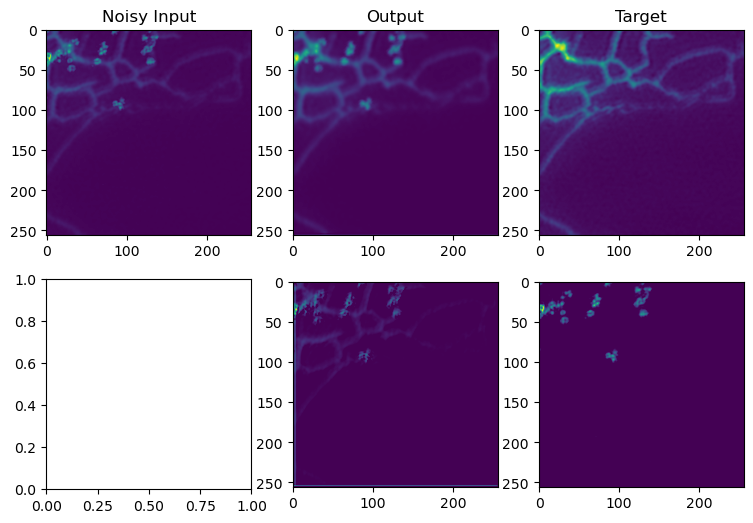

In [10]:
idx = 3
print(f"Index: {idx}")
img_sz = 3
ncols = 3
nrows = 2
_, ax = plt.subplots(figsize=(img_sz*ncols, img_sz*nrows), ncols=ncols,nrows=nrows)
ax[0,0].imshow(test_inputs[idx ,0])
ax[0,1].imshow(test_outputs[idx, 0],vmin = test_targets[idx, 0].min())
ax[0,2].imshow(test_targets[idx, 0])
ax[1,1].imshow(test_outputs[idx,1], vmin = test_targets[idx, 1].min())
ax[1,2].imshow(test_targets[idx,1])

ax[0,0].set_title('Noisy Input')
ax[0,1].set_title('Output')
ax[0,2].set_title('Target')

## Stitching Predictions


In [11]:
from predtiler.dataset import get_tiling_dataset, get_tile_manager

patch_size = 256
tile_size = 128
data_shape = dataset.c2_data.shape[::-1] # size of the data you are working with
manager = get_tile_manager(data_shape=data_shape, tile_shape=(1,tile_size,tile_size), 
                               patch_shape=(1,patch_size,patch_size))

    
dset_class = get_tiling_dataset(BioSRDataLoader, manager)
dataset = dset_class(root_dir='/group/jug/ashesh/data/BioSR/', 
                                resize_to_shape=None,
                                transform=None,
                                noisy_data=True,
                                noise_factor=1000, 
                                gaus_factor=1000, patch_size = patch_size
                                )

test_loader = DataLoader(dataset, batch_size=2, shuffle=False, num_workers=4)

Norm Param:  0 0 65535 65535
c1_data shape: (1004, 1004, 68)
c2_data shape: (1004, 1004, 54)


In [12]:
from predtiler.tile_stitcher import stitch_predictions

predictions = []
targets = []
for inp, targ in test_loader:
    inp, targ = inp.cuda(), targ.cuda()
    if len(inp.shape) == 3:  
        inp = inp.unsqueeze(1)
    if len(targ.shape) == 3:
        targ = targ.unsqueeze(1)        
    pred = model(inp)
    
    
    pred[:,0,:,:] = pred[:,0,:,:]*(c1_max - c1_min) + c1_min
    pred[:,1,:,:] = pred[:,1,:,:]*(c2_max - c2_min) + c2_min
    
    predictions.append(pred.cpu().detach().numpy())
    
    
    targ[:,0,:,:] = targ[:,0,:,:]*(c1_max - c1_min) + c1_min
    targ[:,1,:,:] = targ[:,1,:,:]*(c2_max - c2_min) + c2_min
    
    targets.append(targ.cpu().detach().numpy())

predictions = np.concatenate(predictions, axis = 0) # shape: (number_of_patches, C, patch_size, patch_size)
stitched_pred = stitch_predictions(predictions, dataset.tile_manager)
targets = np.concatenate(targets, axis = 0)
print(targets.shape)
print(manager)
print(predictions.shape)
print(stitched_pred.shape)

[54, 1004, 1004, 2]
(2646, 2, 256, 256)
TileIndexManager(data_shape=(54, 1004, 1004), grid_shape=(1, 128, 128), patch_shape=(1, 256, 256), tiling_mode=2)
(2646, 2, 256, 256)
(54, 1004, 1004, 2)


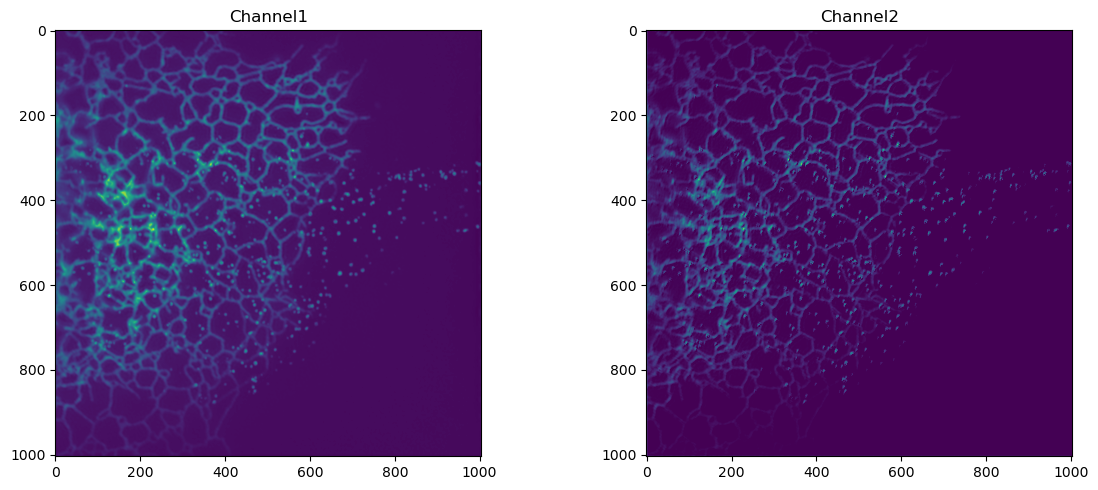

In [13]:
# Crea la figura con 1 riga e 2 colonne
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 riga, 2 colonne

# Primo subplot
ax1.imshow(stitched_pred[0,:, :,0],vmin = test_targets[0,0,:,:].min())
ax1.set_title('Channel1')

# Secondo subplot
ax2.imshow(stitched_pred[0,:, :,1], vmin = test_targets[0,0,:,:].min())
ax2.set_title('Channel2')
# Mostra il grafico
plt.tight_layout()  # Adatta il layout per evitare sovrapposizioni
plt.show()


In [14]:
from data_loader.biosr_dataloader import BioSRDataLoaderNoPatching
dataset_no_patching = BioSRDataLoaderNoPatching(root_dir='/group/jug/ashesh/data/BioSR/', 
                              resize_to_shape=None,
                              transform=None,
                              noisy_data=True,
                              noise_factor=1000, 
                              gaus_factor=1000,
                              patch_size=patch_size)


dataloader = DataLoader(dataset_no_patching, batch_size=1, shuffle=False, num_workers=15)

Norm Param:  0 0 65535 65535
c1_data shape: (1004, 1004, 68)
c2_data shape: (1004, 1004, 54)


In [15]:
from predtiler.tile_stitcher import stitch_predictions

predictions = []
targets = []
for inp, targ in dataloader:
    inp, targ = inp.cuda(), targ.cuda()
    if len(inp.shape) == 3:  
        inp = inp.unsqueeze(1)
    if len(targ.shape) == 3:
        targ = targ.unsqueeze(1)        
    targ[:,0,:,:] = targ[:,0,:,:]*(c1_max - c1_min) + c1_min
    targ[:,1,:,:] = targ[:,1,:,:]*(c2_max - c2_min) + c2_min
    
    targets.append(targ.cpu().detach().numpy())
    
targets = np.concatenate(targets, axis = 0)
print(targets.shape)

(54, 2, 1004, 1004)


In [16]:
from collections import defaultdict
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from utils.util_calculate_psnr_ssim import calculate_psnr, calculate_ssim
from core.psnr import PSNR

psnr_arr = {0: [], 1: []}
for ch_idx in range(targets.shape[1]):
    if ch_idx == 0:
        data_range = c1_max - c1_min
        
    else: 
        data_range = c2_max - c2_min
    psnr_arr[ch_idx].append(PSNR(targets[:,ch_idx,:,:], stitched_pred[:,:,:,ch_idx], range_= data_range))

print(psnr_arr)
print("psnr channel 1:", np.mean(psnr_arr[0]))
print("psnr channel 2:", np.mean(psnr_arr[1]))


{0: [tensor([30.0256, 30.6977, 31.8242, 31.9171, 31.1387, 31.1304, 30.2579, 31.4565,
        32.2652, 30.5919, 31.1071, 31.1528, 31.8490, 32.1367, 30.9531, 29.1890,
        32.8494, 32.3164, 32.4048, 31.3007, 28.4027, 27.9099, 32.3313, 30.9416,
        31.3143, 31.5405, 31.1933, 31.6703, 31.6877, 30.2110, 31.1433, 29.4347,
        29.9748, 31.1283, 31.9718, 29.9063, 30.1059, 30.4835, 30.9391, 28.4961,
        28.3244, 31.7443, 31.3579, 31.7178, 30.7651, 30.8419, 32.3343, 30.5125,
        30.7765, 29.2018, 28.7348, 31.7488, 31.5784, 31.1488])], 1: [tensor([28.3196, 29.3805, 30.6639, 29.8535, 29.8418, 29.5334, 28.7110, 30.2955,
        31.0518, 29.2560, 30.0741, 29.6522, 30.4183, 30.5196, 29.4975, 27.7016,
        31.2490, 30.8585, 30.6268, 30.3004, 27.3670, 26.4525, 31.1854, 29.5235,
        29.6041, 30.2020, 29.5176, 30.5836, 30.2195, 28.7745, 29.9430, 28.1802,
        28.4216, 29.4092, 30.6978, 28.4969, 28.8560, 28.9220, 29.8448, 27.0209,
        26.8755, 30.1666, 30.1988, 29.8009, 28

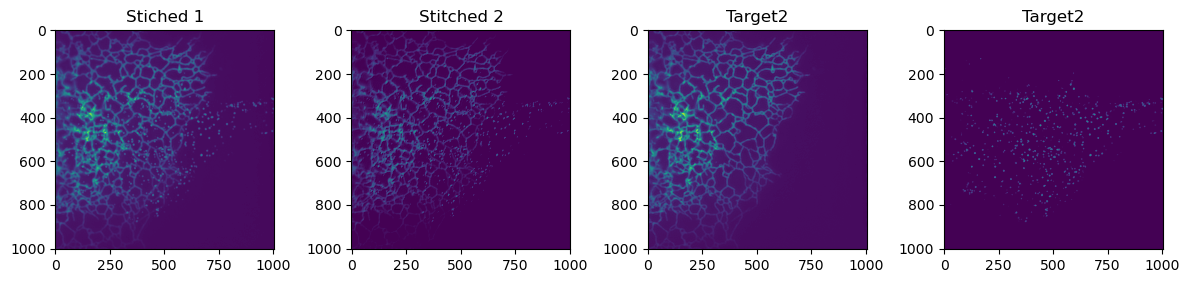

In [17]:
# Crea la figura con 1 riga e 2 colonne
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 5))  # 1 riga, 2 colonne

inputs, target = noisy_train_dataset[0]


# Primo subplot
ax1.imshow(stitched_pred[0,:,:,0],vmin = targets[0,0,:,:].min())
ax1.set_title('Stiched 1')

# Secondo subplot
ax2.imshow(stitched_pred[0,:,:,1],vmin = targets[0,1,:,:].min())
ax2.set_title('Stitched 2')

# Secondo subplot
ax3.imshow(targets[0,0,:, :])
ax3.set_title('Target2')


# Secondo subplot
ax4.imshow(targets[0,1,:,:])
ax4.set_title('Target2')

# Mostra il grafico
plt.tight_layout()  # Adatta il layout per evitare sovrapposizioni
plt.show()